This notebook is to see the effect of the $\sigma$ and $p(x)$ (estimate with a normalising flow until I think of something better or switch examples)

In [1]:
import itertools
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy

from tqdm import tqdm

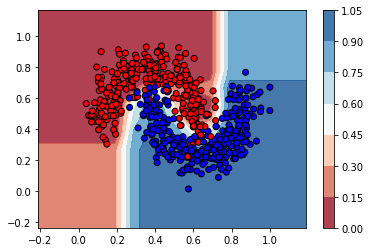

In [2]:
# Make dataset and train a random forest classifier

X, y = sklearn.datasets.make_moons(n_samples=3000, noise=0.20)
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

clf = RandomForestClassifier().fit(X_train, y_train)

h = 0.1
x_min, x_max = X_train[:, 0].min() - .25, X_train[:, 0].max() + .25
y_min, y_max = X_train[:, 1].min() - .25, X_train[:, 1].max() + .25
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict_proba(np.stack([xx.ravel(), yy.ravel()]).T)[:, 1]
cm = plt.cm.RdBu
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=cm, alpha=.8)
plt.colorbar()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')

In [3]:
# Load normalising flow
import keras
from flows import *
nf_model = RealNVP(num_coupling_layers=6)
nf_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
nf_model.load_weights('/Users/alex/Documents/surrogate_agree/nf_weights/checkpoint')

2022-05-26 18:06:05.920493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we want to see the behaviour of our distance for different sampling radius ($\sigma$) and how this changed with the probability of the point $p(x)$ for different levels of transformation

In [119]:
sigmas = np.linspace(0.1, 0.6, 10)
transformers = []
n_quantiles = np.arange(2, 100, 10)
print(n_quantiles)
for q in n_quantiles:
    transformer = QuantileTransformer(n_quantiles=q)
    transformer.fit(X_train)
    transformers.append(transformer)

[ 2 12 22 32 42 52 62 72 82 92]


In [120]:
# For each x_train we'll fit a surrogate and measure the distance
xx, yy = np.meshgrid(np.arange(0.0, 1.1, 0.05),
                     np.arange(0.0, 1.1, 0.05))
points = np.stack([xx.ravel(), yy.ravel()]).T
all_combinations = list(itertools.product(sigmas, points))
parameters = []
distances = []
px = []
n_samples = 100

X_sample, _ = sklearn.datasets.make_moons(n_samples=50000, noise=0.2)

for sigma, query_point in tqdm(all_combinations):
    org_data = X_sample[np.where(
        np.logical_and(
            np.logical_and(X_sample[:,0]>=query_point[0]-sigma, X_sample[:,0]<=query_point[0]+sigma),
            np.logical_and(X_sample[:,1]>=query_point[1]-sigma, X_sample[:,1]<=query_point[1]+sigma)))]
    org_data = np.random.permutation(org_data)[0:n_samples]

    # Ground truth
    ground_truth = Ridge()
    prediction_probs = clf.predict(org_data)
    ground_truth.fit(org_data, prediction_probs)
    gt_var = np.hstack([ground_truth.coef_, ground_truth.intercept_])
    
    for i, transformer in enumerate(transformers):
        model = Ridge()
        ranges = transformer.transform(np.array([[query_point[0]-sigma, query_point[1]-sigma], [query_point[0]+sigma, query_point[1]+sigma]]))
        np.random.seed(42)
        data = np.random.uniform(low=[ranges[0][0], ranges[0][1]],
                                 high=[ranges[1][0], ranges[1][1]],
                                 size=(n_samples, 2))
        inv_data = transformer.inverse_transform(data)
        prediction_probs = clf.predict(inv_data)
        model.fit(inv_data, prediction_probs)
        px.append(nf_model.log_loss(np.expand_dims(query_point, 0)).numpy())
        distances.append(mean_squared_error(gt_var, np.hstack([model.coef_, model.intercept_])**2))
        parameters.append((sigma, n_quantiles[i], query_point))

100%|███████████████████████████████████████| 4840/4840 [26:03<00:00,  3.10it/s]


In [121]:
import pandas as pd
data = [parameters[i] + (distances[i], px[i]) for i in range(len(parameters))]
df = pd.DataFrame(
    data,
    columns=['sigma', 'n_quantiles', 'point', 'dist', 'px'])
max_dist = df['dist'].max()
min_dist = df['dist'].min()

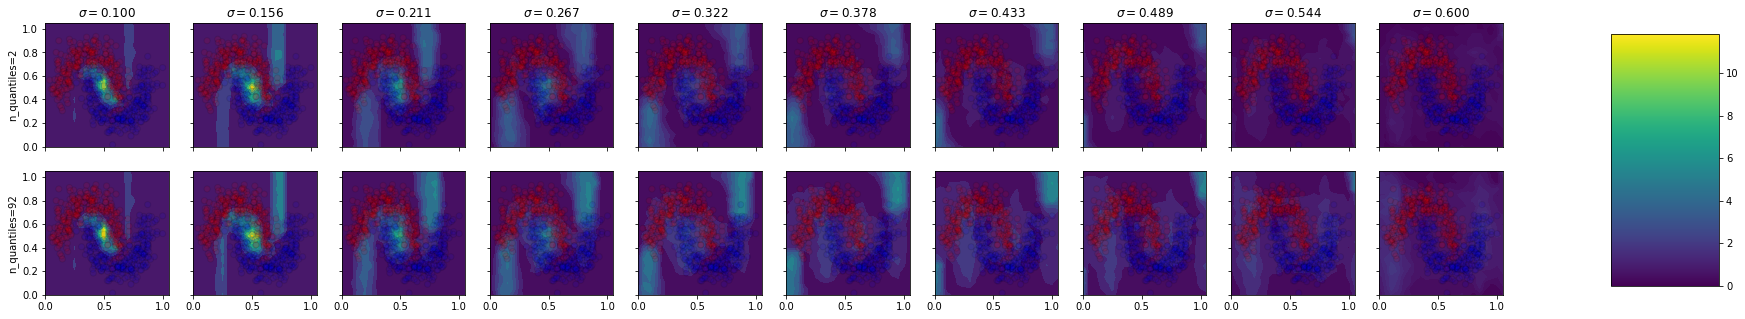

In [126]:
# Print some for n_quartiles=2 and n_quartiles=92
fig, axs = plt.subplots(2, 10, figsize=(30, 5), sharex=True, sharey=True)
from matplotlib.colors import Normalize
import matplotlib
normalizer=Normalize(min_dist,max_dist)
im= matplotlib.cm.ScalarMappable(norm=normalizer)
for i, (name, group) in enumerate(df.groupby('sigma')):
    temp_df2 = group[group['n_quantiles']==2]
    c = axs[0][i].contourf(xx, yy, np.array(temp_df2['dist']).reshape(xx.shape), vmin=min_dist, vmax=max_dist)
    
    temp_df2 = group[group['n_quantiles']==92]
    c = axs[1][i].contourf(xx, yy, np.array(temp_df2['dist']).reshape(xx.shape), vmin=min_dist, vmax=max_dist)
    
    axs[0][i].set_title(r'$\sigma=%.3f$'%name)
    
    axs[0][i].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k', alpha=0.1)
    axs[1][i].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k', alpha=0.1)
    
axs[0][0].set_ylabel('n_quantiles=2')
axs[1][0].set_ylabel('n_quantiles=92')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

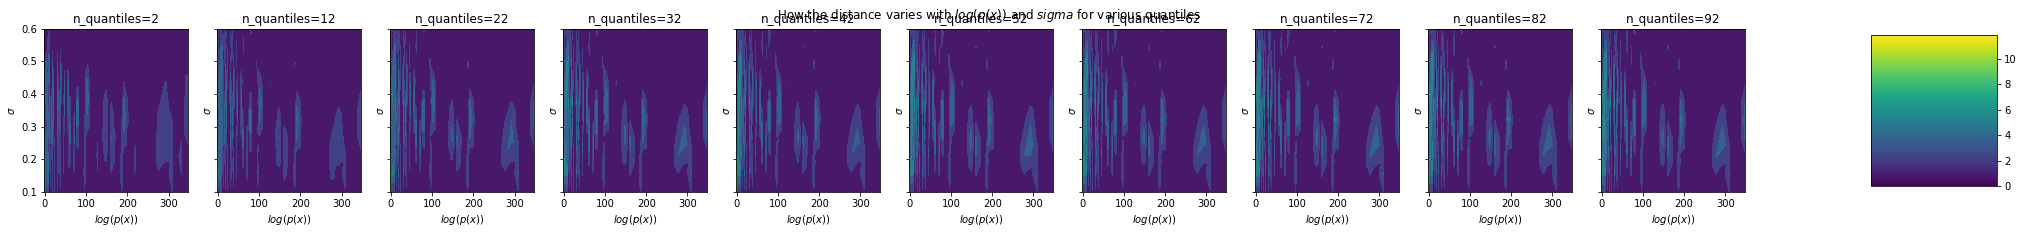

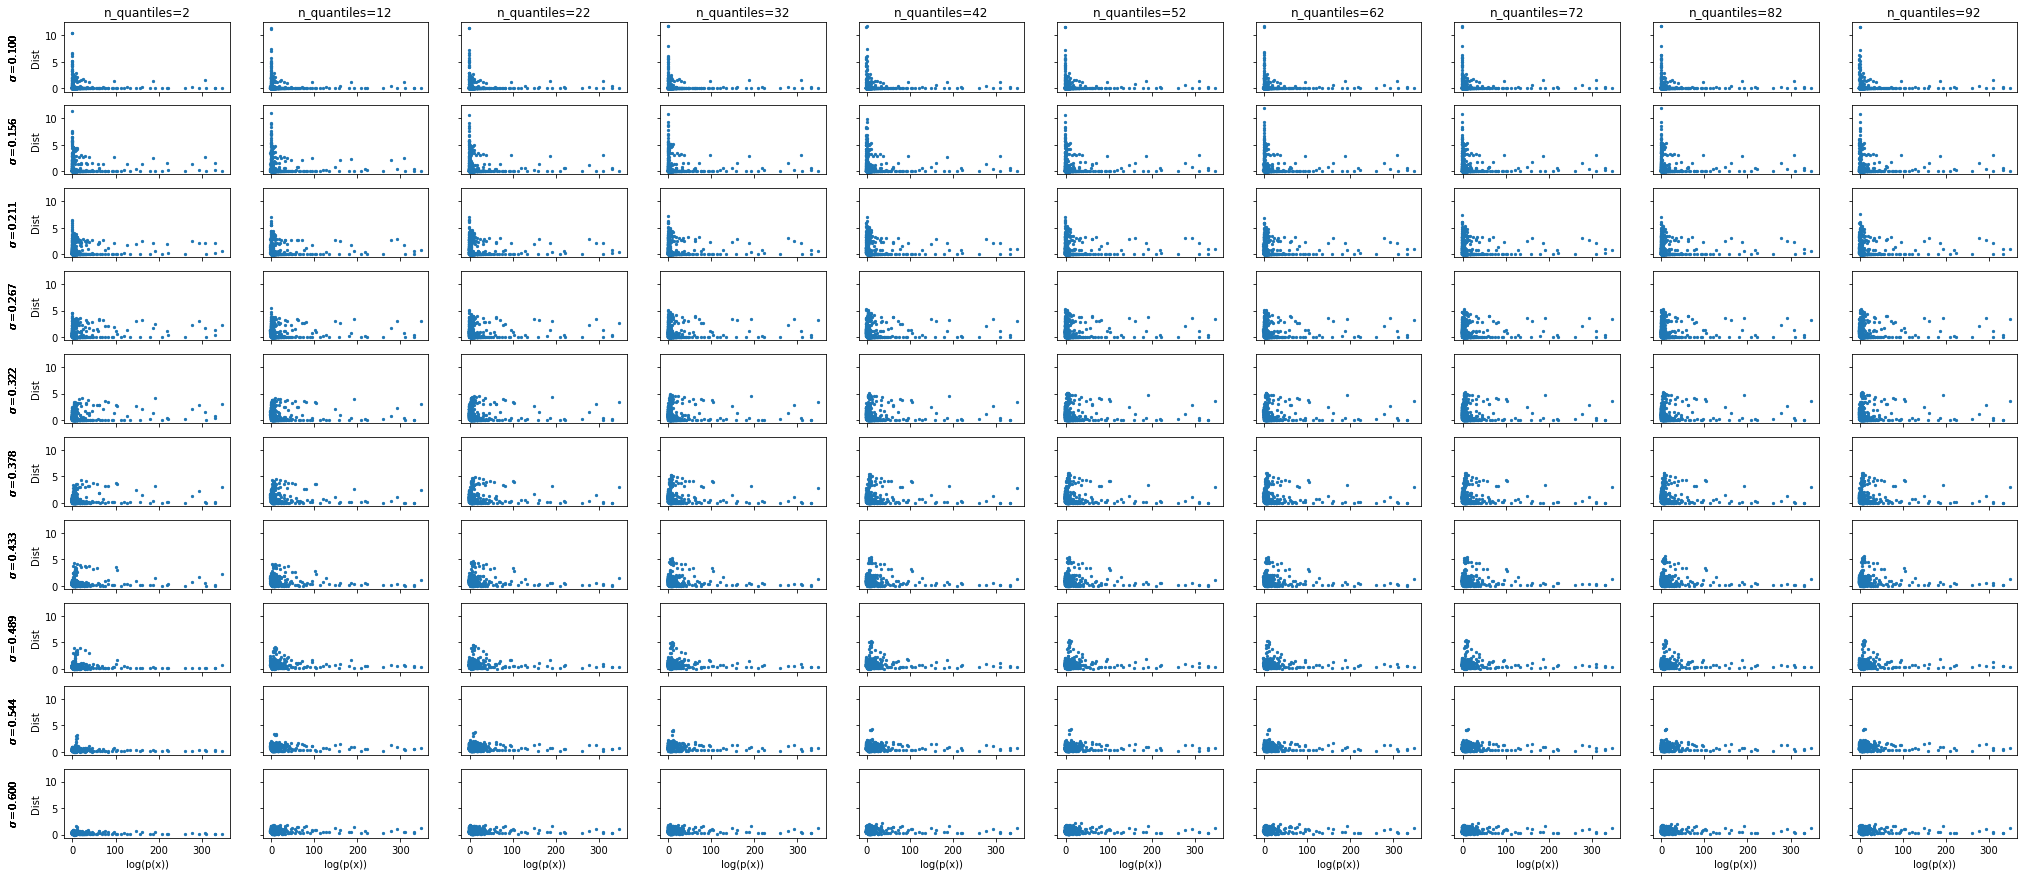

In [144]:
# See how px and sigma affects the distances
fig, axs = plt.subplots(1, 10, figsize=(35, 3), sharey='row')
fig.suptitle(r'How the distance varies with $log(p(x))$ and $sigma$ for various quantiles')
for i, (name, group) in enumerate(df.groupby('n_quantiles')):
    axs[i].set_title('n_quantiles=%d'%name)
    axs[i].tricontourf(np.array(group['px']), np.array(group['sigma']),  np.array(group['dist']), vmin=min_dist, vmax=max_dist)
    axs[i].set_xlabel(r'$log(p(x))$')
    axs[i].set_ylabel(r'$\sigma$')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig, axs = plt.subplots(10, 10, figsize=(35, 15), sharey=True, sharex=True)
for i, (name, group) in enumerate(df.groupby('n_quantiles')):
    axs[-1][i].set_xlabel('log(p(x))')
    axs[0][i].set_title('n_quantiles=%d'%name)
    for k, (name2, group2) in enumerate(group.groupby('sigma')):
        axs[k][0].set_ylabel('Dist')
        axs[k][0].annotate(r'$\sigma=%.3f$'%name2, (0, 0.5), xytext=(-45, 0), ha='right', va='center',
                size=10, rotation=90, xycoords='axes fraction',
                textcoords='offset points')
        axs[k][i].scatter(np.array(group2['px']), np.array(group2['dist']), s=5)
        